In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

# Set the correct file path
file_path = r'C:\Users\Katarina\OneDrive\Desktop\final_cleaned_financial_data_v2.csv'

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Load the data
df = pd.read_csv(file_path)

# Select features
features_to_exclude = ['marketcap', 'ev', 'marketcap_first_day', 'value', 'assetsc', 'investmentsnc', 'investmentsc',
                       'FCF_to_Revenue_signed_log', 'FCF_to_Revenue', 'revenue', 'ticker', 'name', 'sector', 'industry',
                       'scalemarketcap', 'firstpricedate', 'lastpricedate', 'date_first_day', 'lastupdated',
                       'date_first_action', 'action', 'year_after_date', 'first_year_actions']

features = [col for col in df.columns if col not in features_to_exclude]

# Prepare X and y
X = df[features]
y = df['marketcap']

# Handle missing values
X = X.fillna(X.mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Mean Squared Error: 1.0171082015379905e-11
R-squared Score: 0.999999999989967

Top 10 Most Important Features:
         feature  importance
7             pb    0.208231
1         assets    0.177433
4            fcf    0.170551
6             pe    0.100415
2    liabilities    0.073446
3         equity    0.071792
5         ebitda    0.028240
38   investments    0.026422
0         netinc    0.021652
10  pb_first_day    0.017056


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

file_path = r'C:\Users\Katarina\OneDrive\Desktop\final_cleaned_financial_data_v2.csv'

# Load the data
print("Loading data...")
df = pd.read_csv(file_path)

# Feature engineering
print("Engineering features...")
df['debt_to_equity'] = df['liabilities'] / df['equity']
df['current_ratio'] = df['assetsc'] / df['liabilities']

# Select features
features_to_exclude = ['marketcap', 'ev', 'marketcap_first_day', 'value', 'ticker', 'name', 'sector', 'industry',
                       'scalemarketcap', 'firstpricedate', 'lastpricedate', 'date_first_day', 'lastupdated',
                       'date_first_action', 'action', 'year_after_date', 'first_year_actions']

features = [col for col in df.columns if col not in features_to_exclude]

# Prepare X and y
X = df[features]
y = df['marketcap']

# Handle missing values
X = X.fillna(X.mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save preprocessed data
np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_test_scaled.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

print("Preprocessing complete. Data saved.")

Loading data...
Engineering features...
Preprocessing complete. Data saved.


In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load preprocessed data
X_train_scaled = np.load('X_train_scaled.npy')
X_test_scaled = np.load('X_test_scaled.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    return cv_scores.mean(), cv_scores.std()

# Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_mean, rf_cv_std = evaluate_model(rf_model, X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("\nRandom Forest:")
print(f"Cross-validation R2: {rf_cv_mean:.4f} (+/- {rf_cv_std:.4f})")
print(f"Test MSE: {rf_mse:.4e}")
print(f"Test R2: {rf_r2:.4f}")

Training Random Forest...

Random Forest:
Cross-validation R2: 1.0000 (+/- 0.0000)
Test MSE: 4.6155e-09
Test R2: 1.0000


In [7]:
print("Training XGBoost...")
xgb_model = XGBRegressor(random_state=42)
xgb_cv_mean, xgb_cv_std = evaluate_model(xgb_model, X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("\nXGBoost:")
print(f"Cross-validation R2: {xgb_cv_mean:.4f} (+/- {xgb_cv_std:.4f})")
print(f"Test MSE: {xgb_mse:.4e}")
print(f"Test R2: {xgb_r2:.4f}")

Training XGBoost...

XGBoost:
Cross-validation R2: 1.0000 (+/- 0.0000)
Test MSE: 2.3711e-05
Test R2: 1.0000


In [8]:
print("Training LightGBM...")
lgb_model = LGBMRegressor(random_state=42)
lgb_cv_mean, lgb_cv_std = evaluate_model(lgb_model, X_train_scaled, y_train)
lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_mse = mean_squared_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

print("\nLightGBM:")
print(f"Cross-validation R2: {lgb_cv_mean:.4f} (+/- {lgb_cv_std:.4f})")
print(f"Test MSE: {lgb_mse:.4e}")
print(f"Test R2: {lgb_r2:.4f}")

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11226
[LightGBM] [Info] Number of data points in the train set: 241037, number of used features: 58
[LightGBM] [Info] Start training from score 0.000694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11227
[LightGBM] [Info] Number of data points in the train set: 241037, number of used features: 58
[LightGBM] [Info] Start training from score -0.000285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11223
[LightGBM] [Info] Number of data points in the train set: 241038, number of used features: 58

In [9]:
np.save('feature_importance.npy', rf_model.feature_importances_)

In [22]:
print("Target variable statistics:")
print(f"Mean: {np.mean(y)}")
print(f"Std: {np.std(y)}")
print(f"Min: {np.min(y)}")
print(f"Max: {np.max(y)}")

Target variable statistics:
Mean: -9.659496277678184e-18
Std: 0.9999999999999999
Min: -0.3968772901300334
Max: 13.947370729310272


In [23]:
constant_features = []
for col in X.columns:
    if X[col].nunique() == 1:
        constant_features.append(col)
    elif X[col].nunique() / len(X) < 0.01:  # Less than 1% unique values
        constant_features.append(col)

print(f"Constant or near-constant features: {constant_features}")

Constant or near-constant features: ['revenue', 'netinc', 'assets', 'liabilities', 'equity', 'fcf', 'ebitda', 'pe', 'pb', 'evebit', 'evebitda', 'pb_first_day', 'pe_first_day', 'ps', 'revenue_missing', 'netinc_missing', 'assets_missing', 'liabilities_missing', 'equity_missing', 'fcf_missing', 'ebitda_missing', 'marketcap_missing', 'pe_missing', 'pb_missing', 'event_missing', 'date_first_action_missing', 'action_missing', 'value_missing', 'scalemarketcap_missing', 'ps_missing', 'investmentsc', 'investmentsnc', 'roa', 'roe', 'roic', 'ros', 'FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities', 'FCF_to_EBITDA_log', 'FCF_to_Revenue_log', 'Assets_to_Liabilities_log', 'FCF_to_EBITDA_signed_log', 'FCF_to_Revenue_signed_log', 'Revenue_to_EBITDA_signed_log', 'Assets_to_Liabilities_signed_log', 'size_Large', 'size_Medium', 'size_Small', 'debt_to_equity']


Linear Regression:
  Train R2: 0.3818
  Test R2: 0.3772

Ridge Regression:
  Train R2: 0.3818
  Test R2: 0.3772

Lasso Regression:
  Train R2: 0.0000
  Test R2: -0.0000

Random Forest:
  Train R2: 1.0000
  Test R2: 1.0000



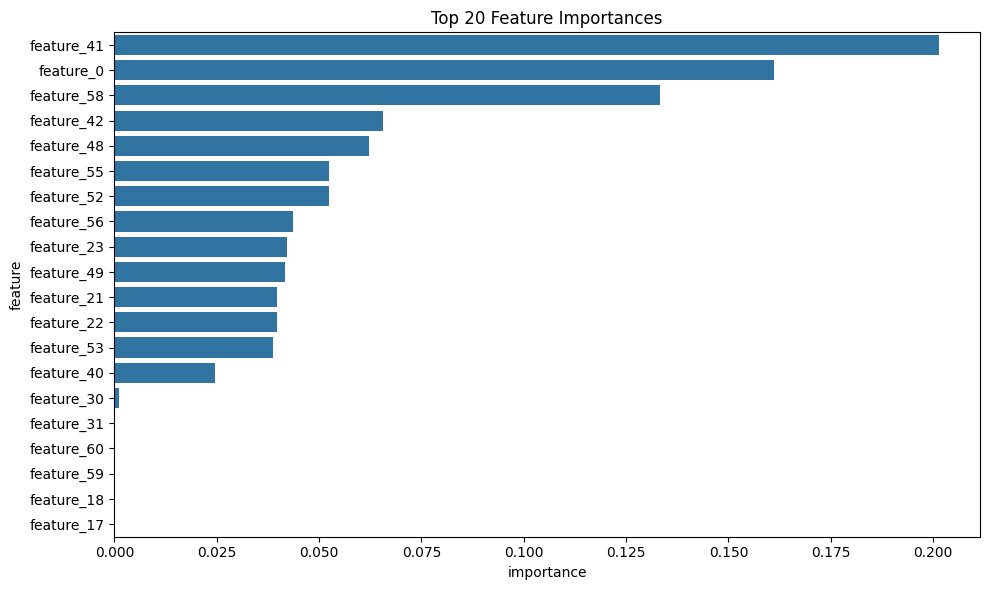

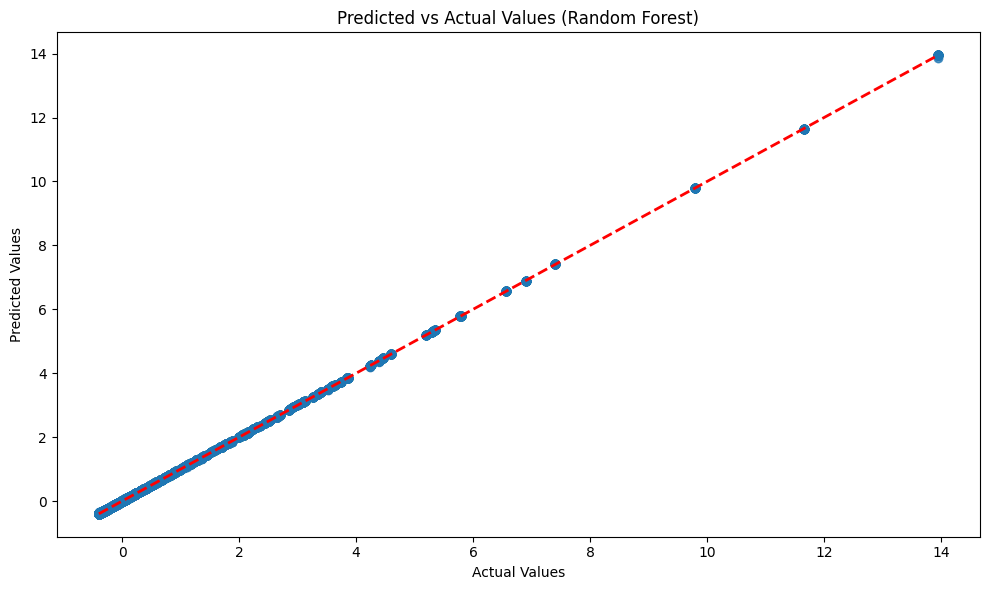

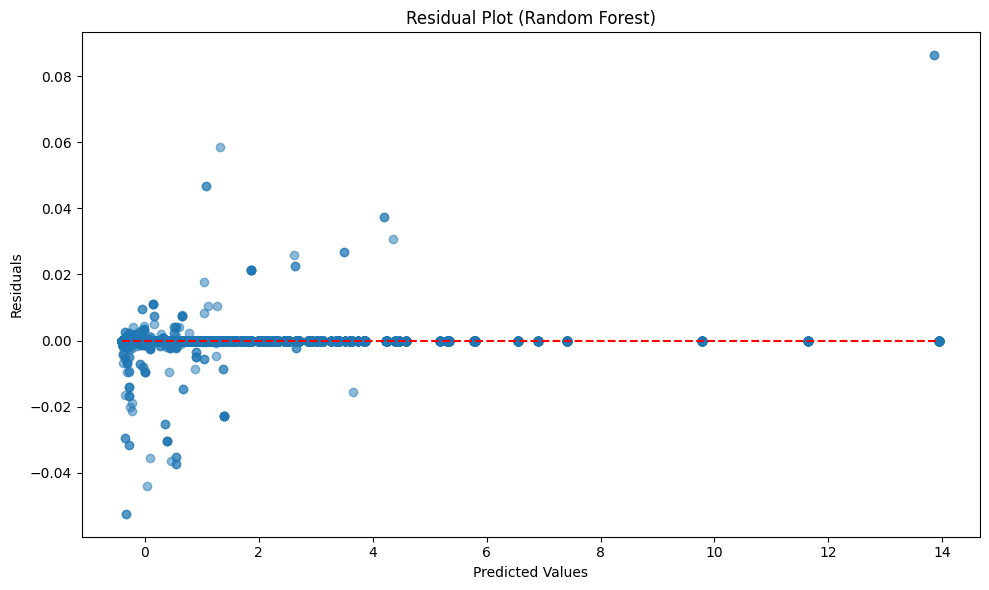

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
X_train_scaled = np.load('X_train_scaled.npy')
X_test_scaled = np.load('X_test_scaled.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Convert numpy arrays back to pandas DataFrames
feature_names = [f'feature_{i}' for i in range(X_train_scaled.shape[1])]
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Step 1: Remove constant and near-constant features
variance_threshold = VarianceThreshold(threshold=0.01)
X_train_var = variance_threshold.fit_transform(X_train_df)
X_test_var = variance_threshold.transform(X_test_df)

# Get the names of the selected features
selected_features = X_train_df.columns[variance_threshold.get_support()].tolist()

# Step 2: Feature selection using SelectKBest
k_best = SelectKBest(score_func=f_regression, k=20)
X_train_selected = k_best.fit_transform(X_train_var, y_train)
X_test_selected = k_best.transform(X_test_var)

# Get the names of the top features
top_features = [selected_features[i] for i in k_best.get_support(indices=True)]

# Step 3: Train and evaluate different models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    train_score = model.score(X_train_selected, y_train)
    test_score = model.score(X_test_selected, y_test)
    results[name] = {'Train R2': train_score, 'Test R2': test_score}

# Print results
for name, scores in results.items():
    print(f"{name}:")
    print(f"  Train R2: {scores['Train R2']:.4f}")
    print(f"  Test R2: {scores['Test R2']:.4f}")
    print()

# Step 4: Feature importance analysis (for Random Forest)
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': top_features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Step 5: Scatter plot of predicted vs actual values
y_pred = rf_model.predict(X_test_selected)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Random Forest)')
plt.tight_layout()
plt.show()

# Step 6: Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.tight_layout()
plt.show()

feature_41: FCF_to_EBITDA_signed_log
feature_0: revenue
feature_58: debt_to_equity
feature_42: FCF_to_Revenue_signed_log
feature_48: size_Small
feature_55: evebitda
feature_52: pb
feature_56: pb_first_day
feature_23: ebitda_missing
feature_49: pe
feature_21: fcf_missing
feature_22: ebitda
feature_53: pe_first_day
feature_40: FCF_to_EBITDA_log
feature_30: investmentsnc
These features represent a mix of financial ratios, log-transformed variables, categorical indicators, and fundamental financial metrics.